In [1]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps

In [2]:
dir(pn.response)

['NaturalCubicFrameSpline',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

In [3]:
x = np.array([0,1,2,5.0/2.0,5])
y = np.array([[0,1,8,9,-5]])
sp = pn.response.NaturalCubicFrameSpline()
sp.build(x,y)

In [ ]:
print(sp.coeffs)

In [5]:
xi = np.linspace(0.01,4.99,100)
yi = []
for x in xi:
    yi.append(sp.eval(x))

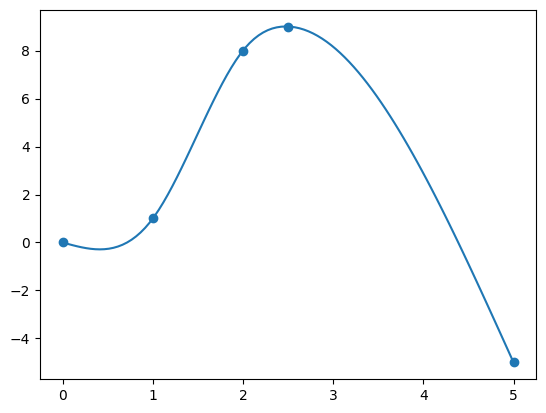

In [6]:
import matplotlib.pyplot as plt

plt.plot(xi,yi)
plt.scatter([0,1,2,5.0/2.0,5],[0,1,8,9,-5])

In [7]:
evs = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not evs:
    print("Error: failed to open input file")

In [8]:
wf = pn.WeightCalcFactory()
nrw = wf.make(evs, {"plugin_name":"NReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

Initializing with neut.t2kflux_numu_C_nofsi.card
 CRSPATH_ENV: /opt/neut/git_master/share/neut/crsdat
 Reading neut.t2kflux_numu_C_nofsi.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.t2kflux_numu_C_nofsi.card as a card file
Reading bank: NEUT from card file: neut.t2kflux_numu_C_nofsi.card
Reading bank: NEUT from card file: neut.t2kflux_numu_C_nofsi.card
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/git_master/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            1
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            1
 NECARD : NUCDEXITE =            0
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H 

In [9]:
pps.load_text("""

std::vector<double> kinvars(HepMC3::GenEvent const &ev){
  std::vector<double> rtn(6,0xdeadbeef);

  if(!ps::event::has_beam_part(ev,14)) {
      return rtn;
  }
  auto const &nu = ps::event::beam_part(ev,14);

  if(!ps::event::has_out_part(ev,13)) {
      return rtn;
  }
  auto const &mu = ps::event::hm_out_part(ev,13);

  auto qv = nu->momentum() - mu->momentum();

  rtn[0] = nu->momentum().e()  / ps::unit::GeV;
  rtn[1] = qv.e() / ps::unit::GeV;
  rtn[2] = qv.p3mod() / ps::unit::GeV;
  rtn[3] = -qv.interval() / (ps::unit::GeV2);

  rtn[4] = mu->momentum().p3mod() / ps::unit::GeV;
  rtn[5] = std::cos(mu->momentum().theta());

  return rtn;
}

int isCCQE(HepMC3::GenEvent const &ev){
    return ps::event::signal_process_id(ev) == 200;
}
""")

True

In [10]:
vals = [0.8,1,1.2,1.3]
def wghts(ev):
    resp = []
    for x in vals:
        nrw.set_parameters({"MaCCQE":x})
        resp.append(nrw.calc_weight(ev))
    return resp

In [11]:
fg = pn.EventFrameGen(evs, 250000)\
  .filter(pps.select.get("isCCQE")) \
  .add_columns(["enu","q0","q3","Q2lep","plep","cthetalep"], pps.project.get_vect("kinvars")) \
  .add_columns(["MaCCQE=%s" % x for x in vals], wghts)
print(fg.first(20))

 -------------------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | process.id |    enu |      q0 |      q3 |   Q2lep |   plep | cthetalep | MaCCQE=0.8 | MaCCQE=1 | MaCCQE=1.2 | MaCCQE=1.3 |
 -------------------------------------------------------------------------------------------------------------------------------------------------------
 |            3 |         1 |        200 | 0.3478 | 0.07578 |  0.2856 | 0.07581 | 0.2507 |    0.5864 |     0.8565 |   0.9435 |     0.9979 |      1.017 |
 |            4 |         1 |        200 | 0.6416 |  0.1607 |  0.6537 |  0.4015 | 0.4692 |    0.3396 |     0.6181 |   0.8152 |     0.9919 |      1.069 |
 |            8 |         1 |        200 | 0.8723 |  0.1205 |  0.3886 |  0.1365 | 0.7444 |    0.8963 |     0.7911 |   0.9123 |     0.9965 |      1.029 |
 |           13 |         1 |        200 | 0.6919 |  0.2165 |  0.8356 |  0.6514 | 

In [ ]:
ef = fg.first(int(1E5))

In [13]:
print(ef)

 -------------------------------------------------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | process.id |    enu |      q0 |      q3 |   Q2lep |   plep | cthetalep | MaCCQE=0.8 | MaCCQE=1 | MaCCQE=1.2 | MaCCQE=1.3 |
 -------------------------------------------------------------------------------------------------------------------------------------------------------
 |            3 |         1 |        200 | 0.3478 | 0.07578 |  0.2856 | 0.07581 | 0.2507 |    0.5864 |     0.8565 |   0.9435 |     0.9979 |      1.017 |
 |            4 |         1 |        200 | 0.6416 |  0.1607 |  0.6537 |  0.4015 | 0.4692 |    0.3396 |     0.6181 |   0.8152 |     0.9919 |      1.069 |
 |            8 |         1 |        200 | 0.8723 |  0.1205 |  0.3886 |  0.1365 | 0.7444 |    0.8963 |     0.7911 |   0.9123 |     0.9965 |      1.029 |
 |           13 |         1 |        200 | 0.6919 |  0.2165 |  0.8356 |  0.6514 | 

In [14]:
sp = pn.response.NaturalCubicFrameSpline()
sp.build(vals, ef.table[0:10,9:])
print(sp.coeffs)

[[ 8.56478843e-01  9.43487144e-01  9.97856570e-01  4.72619870e-01
   3.59884765e-01  2.08506966e-01  0.00000000e+00 -5.63675526e-01
  -1.93213468e-01 -9.39459209e-01  6.17436762e-01  6.44044894e-01]
 [ 6.18115906e-01  8.15162572e-01  9.91914623e-01  1.00297739e+00
   9.49745203e-01  8.05022545e-01 -6.80414527e-18 -2.66160954e-01
  -4.57452341e-01 -4.43601590e-01 -3.18818978e-01  1.52484114e+00]
 [ 7.91050947e-01  9.12259837e-01  9.96537479e-01  6.47191483e-01
   5.23750392e-01  3.40104936e-01 -1.36082905e-17 -6.17205456e-01
  -3.01021823e-01 -1.02867576e+00  5.26972721e-01  1.00340608e+00]
 [ 5.43610007e-01  7.61520174e-01  9.88858852e-01  1.07285379e+00
   1.12294493e+00  1.11409918e+00  0.00000000e+00  2.50455662e-01
  -2.94684377e-01  4.17426103e-01 -9.08566731e-01  9.82281255e-01]
 [ 5.34133628e-01  7.53275050e-01  9.88331140e-01  1.07188076e+00
   1.14335980e+00  1.16764271e+00  1.36082905e-17  3.57395195e-01
  -2.35980652e-01  5.95658659e-01 -9.88959745e-01  7.86602172e-01]
 [ 6.

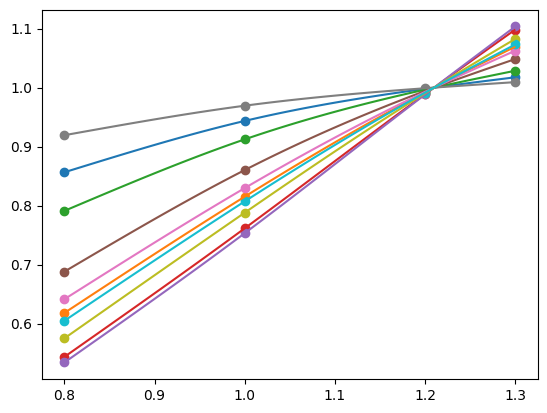

In [15]:
xi = np.linspace(0.801, 1.299, 100)
yi = np.array([sp.eval(v) for v in xi])
for i in range(10):
    plt.plot(xi,yi[:,i])
    plt.scatter(vals, ef.table[i,9:])

In [16]:
eq2 = pn.HistFrame(pn.Binning.lin_space(0,2,25))
eq2.fill_weighted_columns_from_EventFrame(ef,["Q2lep"],ef.column_names[9:])


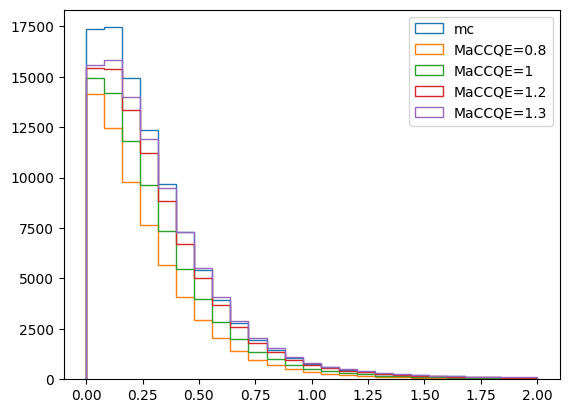

In [17]:
eq2.mpl().hist_all(histtype="step")
plt.legend()
plt.show()

In [18]:
sp = pn.response.NaturalCubicFrameSpline()
sp.build(vals,(eq2.sumweights[:,1:].transpose()/eq2.sumweights[:,0]).transpose())

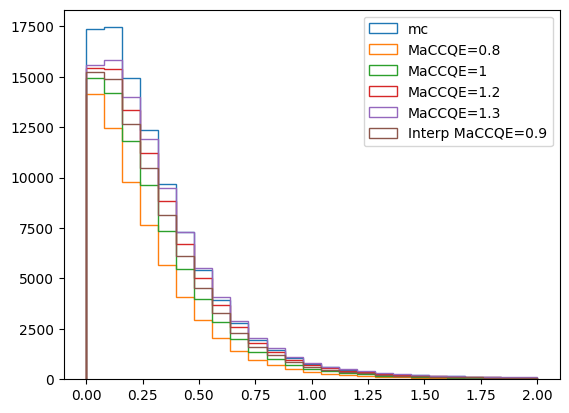

In [19]:
eq2_interp = pn.HistFrame(pn.Binning.lin_space(0,2,25))
eq2_interp.sumweights = eq2.sumweights[:,0]*sp.eval(1.1) 

eq2.mpl().hist_all(histtype="step")
eq2_interp.mpl().hist(histtype="step", label="Interp MaCCQE=0.9")
plt.legend()
plt.show()